In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt

os.chdir("..")
from assistive_arm.utils.data_preprocessing import prepare_mocap_data, prepare_opencap_data, prepare_mocap_force_data, read_headers, export_filtered_force, sync_mocap_with_opencap

## Read data

In [2]:
jae_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Masterarbeit Harvard/Thesis/Subject testing/Subject data/jae_data")
project_moco_data = Path("/Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/")

# Set directories
opencap_data = jae_data / "opencap_data"
mocap_data = jae_data / "mocap_data"
opencap_markers = opencap_data / "MarkerData"

In [3]:
# Read force data
mocap_force_right_coordinates = read_headers(mocap_data / "sit_stand0002_f_20.tsv", 25)[9:21]
mocap_force_right = pd.read_csv(
    mocap_data / "sit_stand0002_f_20.tsv", 
    delimiter="\t", 
    skiprows=26, 
    names=["ground_force_r_vx", "ground_force_r_vy", "ground_force_r_vz", "ground_torque_r_x", "ground_torque_r_y", "ground_torque_r_z", "ground_force_r_px", "ground_force_r_py", "ground_force_r_pz", "nan"])
mocap_force_right = mocap_force_right.reindex(columns=["ground_force_r_vx", "ground_force_r_vy", "ground_force_r_vz", "ground_force_r_px", "ground_force_r_py", "ground_force_r_pz", "ground_torque_r_x", "ground_torque_r_y", "ground_torque_r_z", "nan"])

mocap_force_left_coordinates = read_headers(mocap_data / "sit_stand0002_f_21.tsv", 25)[9:21]
mocap_force_left = pd.read_csv(
    mocap_data / "sit_stand0002_f_21.tsv", 
    delimiter="\t",
    skiprows=26, 
    names=["ground_force_l_vx", "ground_force_l_vy", "ground_force_l_vz", "ground_torque_l_x", "ground_torque_l_y", "ground_torque_l_z", "ground_force_l_px", "ground_force_l_py", "ground_force_l_pz", "nan"])
mocap_force_left = mocap_force_left.reindex(columns=["ground_force_l_vx", "ground_force_l_vy", "ground_force_l_vz", "ground_force_l_px", "ground_force_l_py", "ground_force_l_pz", "ground_torque_l_x", "ground_torque_l_y", "ground_torque_l_z", "nan"])

# Read mocap marker data
mocap_marker_names = read_headers(mocap_data / "sit_stand0002.tsv", 10)[-1][-2:] # Read row 10 and get marker names
mocap_markers = pd.read_csv(mocap_data / "sit_stand0002.tsv", delimiter="\t", skiprows=11)

# Read opencap marker data
headers = read_headers(opencap_markers / "sit_stand_2.trc", 3)  
opencap_markers = pd.read_csv(opencap_markers / "sit_stand_2.trc", delimiter="\t", skiprows=3).tail(-1)

## Process data

In [4]:
# Prepare mocap data
mocap_markers = prepare_mocap_data(mocap_markers, mocap_marker_names)
opencap_markers = prepare_opencap_data(opencap_markers)
mocap_forces_in_opencap_frame = prepare_mocap_force_data(mocap_force_right, mocap_force_left, forces_in_world=True)

In [5]:
mocap_markers, mocap_forces_in_opencap_frame, opencap_markers = sync_mocap_with_opencap(marker_data=mocap_markers, force_data=mocap_forces_in_opencap_frame, opencap_data=opencap_markers)

In [6]:
def transform_force_coordinates(force_trial: pd.DataFrame, new_origin: pd.Series):
    # OpenCap origin in Mocap coordinates, rotated 90 degrees around the x-axis
    T_W_OC = np.array([[1, 0, 0, new_origin.X],
                       [0, 0, -1, new_origin.Y], 
                       [0, 1, 0, 0], # We ignore the Z coordinate because we only care the about the translation on the XY plane
                       [0, 0, 0, 1]])
    
    T_OC_W = np.eye(4)
    T_OC_W[:3, :3] = T_W_OC[:3, :3].T
    T_OC_W[:3, 3] = -T_OC_W[:3, :3] @ T_W_OC[:3, 3]

    # Convert force plate coordinates to MoCap coordinates
    for side in ["r", "l"]:
        cop_cols = [f"ground_force_{side}_px", f"ground_force_{side}_py", f"ground_force_{side}_pz"]
        df_xyz = force_trial.loc[:, cop_cols]
        df_xyz["W"] = 1

        force_cols = [f"ground_force_{side}_vx", f"ground_force_{side}_vy", f"ground_force_{side}_vz"]
        df_vxyz = force_trial.loc[:, force_cols]
        df_vxyz["W"] = 1

        # Transform force vector
        transformed_vxyz = (T_OC_W @ df_vxyz.T).T
        transformed_vxyz.drop(transformed_vxyz.columns[-1], axis=1, inplace=True)
        transformed_vxyz.columns = force_cols
        
        transformed_xyz = (T_OC_W @ df_xyz.T).T
        transformed_xyz.drop(transformed_xyz.columns[-1], axis=1, inplace=True)
        transformed_xyz.columns = cop_cols

        force_trial.loc[:, cop_cols] = transformed_xyz
        force_trial.loc[:, force_cols] = transformed_vxyz

        # Flip y-axis
        force_trial.loc[:, f"ground_force_{side}_vy"] *= -1

    return force_trial

In [7]:
opencap_origin = mocap_markers.Origin.mean(axis=0)
mocap_forces_in_opencap_frame = transform_force_coordinates(force_trial=mocap_forces_in_opencap_frame, new_origin=opencap_origin)

In [8]:
export_filtered_force(mocap_forces_in_opencap_frame, project_moco_data / "forces" / "sit_stand0002_filtered.mot")

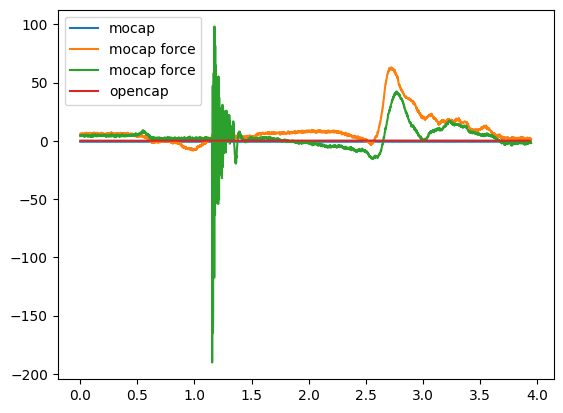

In [9]:
plt.plot(mocap_markers.Time.time, mocap_markers.Knee.X, label="mocap")
plt.plot(mocap_forces_in_opencap_frame.time, mocap_forces_in_opencap_frame.ground_force_r_vx, label="mocap force")
plt.plot(mocap_forces_in_opencap_frame.time, mocap_forces_in_opencap_frame.ground_force_l_vx, label="mocap force")
plt.plot(opencap_markers.Time.t, opencap_markers["LKnee"].X, label="opencap")
plt.legend()

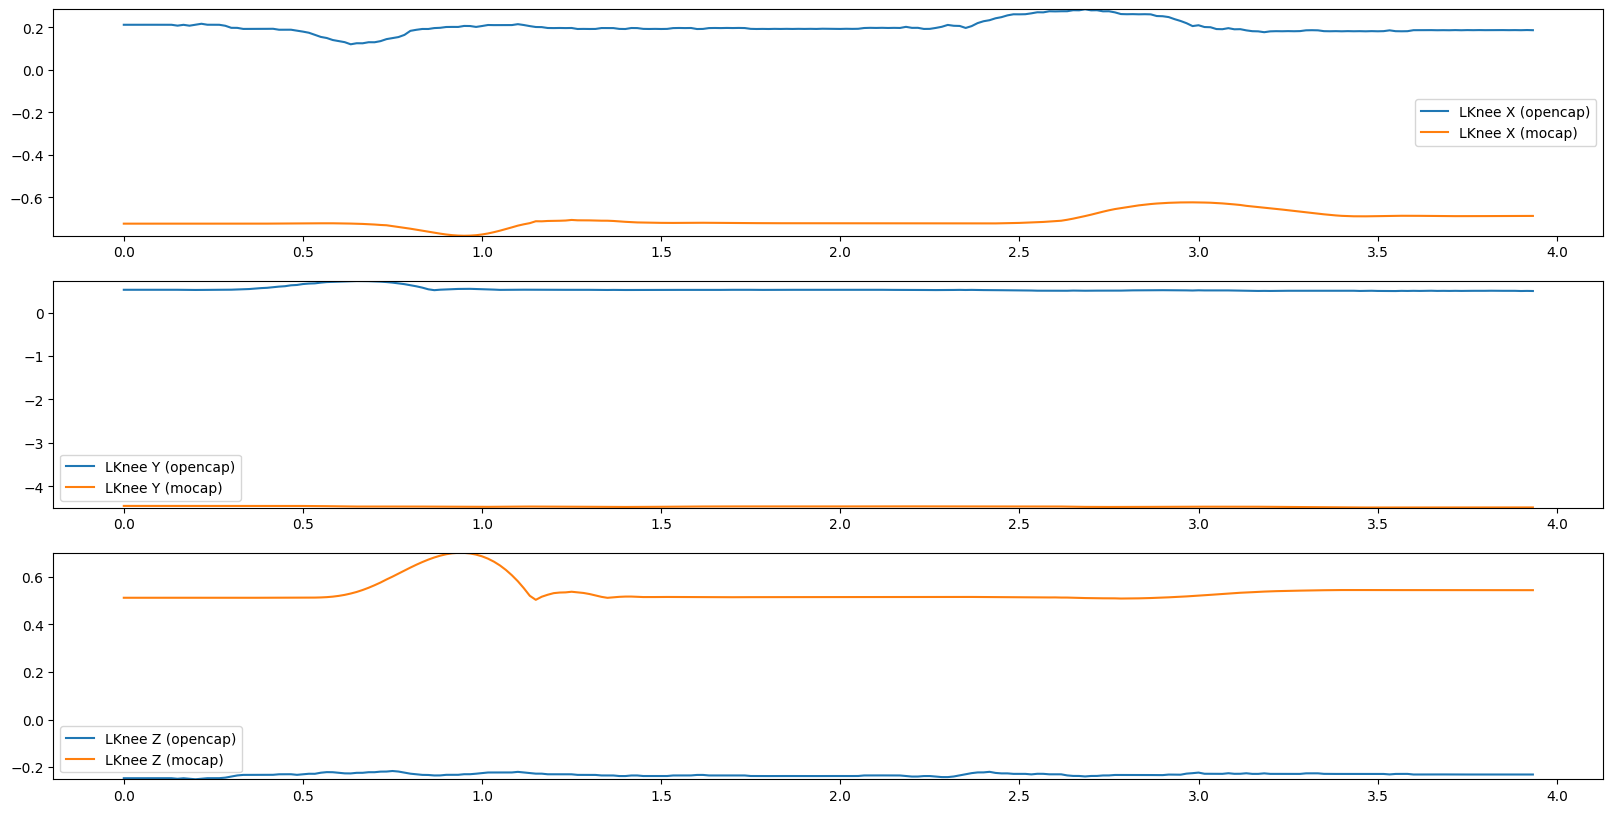

In [10]:
fig, axs = plt.subplots(3, sharex="row", figsize=(20, 10))

# Plot X data
axs[0].plot(opencap_markers["Time"].t, opencap_markers["LKnee"].X, label="LKnee X (opencap)")
axs[0].plot(mocap_markers.Time.time, mocap_markers.Knee.X, label="LKnee X (mocap)")
#axs[0].plot(mocap_force_trial_1_right.time, mocap_force_trial_1_right.FPx, label="LKnee X (mocap force)")
axs[0].legend()

# Plot Y data
axs[1].plot(opencap_markers["Time"].t, opencap_markers["LKnee"].Y, label="LKnee Y (opencap)")
axs[1].plot(mocap_markers.Time.time, mocap_markers.Knee.Y, label="LKnee Y (mocap)")
#axs[1].plot(mocap_force_trial_1_right.timestamp, mocap_force_trial_1_right.FPy, label="LKnee Y (mocap force)")
axs[1].legend()

# Plot Z data
axs[2].plot(opencap_markers["Time"].t, opencap_markers["LKnee"].Z, label="LKnee Z (opencap)")
axs[2].plot(mocap_markers.Time.time, mocap_markers.Knee.Z, label="LKnee Z (mocap)")
#axs[2].plot(mocap_force_trial_1_right.time, mocap_force_trial_1_right.FPz, label="LKnee Z (mocap force)")
axs[2].legend()

axs[0].autoscale(axis='y', tight=True)
axs[1].autoscale(axis='y', tight=True)
axs[2].autoscale(axis='y', tight=True)

# Display the plot
plt.show()